# 0. Loading all Data

In [25]:
%reload_ext autoreload
%autoreload 2
from B_model import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from tensorflow import keras

all_metrics_df,testParamDf = data_generation()

Unique DODs 18
Unique discharging_protocol 23
Unique charging_protocol 47
8
12
5


# Result Selection # =====# Result Selection # =====# Result Selection # =====# Result Selection # =====

In [47]:
result_all = pd.read_csv('result.csv')
result_all = result_all.loc[result_all['error'] != 0]
result_all_selected = result_all.loc[result_all['error'] < 1000]
result_all.shape,result_all_selected.shape

((4320, 8), (3138, 8))

In [48]:
result_all_selected_argu1 = result_all.loc[result_all['argu'] ==1]
result_all_selected_argu1

,Unnamed: 0,argu,loss_fun,class_weight,nl,opt,epochs,error
0,0,1.0,mse,"{0: 1.0, 1: 1.0, 2: 1.0}","[30, 10]",SGD,100.0,591.884646
1,1,1.0,mse,"{0: 1.0, 1: 1.0, 2: 1.0}","[30, 10]",SGD,200.0,566.150001
2,2,1.0,mse,"{0: 1.0, 1: 1.0, 2: 1.0}","[30, 10]",SGD,300.0,496.044002
3,3,1.0,mse,"{0: 1.0, 1: 1.0, 2: 1.0}","[30, 10]",Adam,100.0,410.303547
4,4,1.0,mse,"{0: 1.0, 1: 1.0, 2: 1.0}","[30, 10]",Adam,200.0,336.877759
...,...,...,...,...,...,...,...,...
1075,1075,1.0,mae,"{0: 100000000.0, 1: 10000.0, 2: 1.0}","[90, 70]",Adam,200.0,136.622929
1076,1076,1.0,mae,"{0: 100000000.0, 1: 10000.0, 2: 1.0}","[90, 70]",Adam,300.0,155.215552
1077,1077,1.0,mae,"{0: 100000000.0, 1: 10000.0, 2: 1.0}","[90, 70]",RMSprop,100.0,132.035353
1078,1078,1.0,mae,"{0: 100000000.0, 1: 10000.0, 2: 1.0}","[90, 70]",RMSprop,200.0,217.036689


In [4]:
result_all_selected_argu1.sort_values('error')[0:10]

,Unnamed: 0,argu,loss_fun,class_weight,nl,opt,epochs,error
1022,1022,1.0,mae,"{0: 100000000.0, 1: 10000.0, 2: 1.0}","[100, 80, 60, 10]",Adam,300.0,67.136907
715,715,1.0,mae,"{0: 10000.0, 1: 100.0, 2: 1.0}","[80, 30, 10]",Adam,200.0,72.395349
724,724,1.0,mae,"{0: 10000.0, 1: 100.0, 2: 1.0}","[100, 80, 30, 10]",Adam,200.0,72.875277
287,287,1.0,mse,"{0: 1000000.0, 1: 1000.0, 2: 1.0}","[50, 30, 10]",RMSprop,300.0,73.758606
167,167,1.0,mse,"{0: 10000.0, 1: 100.0, 2: 1.0}","[100, 50, 30, 10]",Adam,300.0,75.728119
430,430,1.0,mse,"{0: 100000000.0, 1: 10000.0, 2: 1.0}","[70, 50, 30, 10]",RMSprop,200.0,75.975400
984,984,1.0,mae,"{0: 100000000.0, 1: 10000.0, 2: 1.0}","[80, 30, 10]",Adam,100.0,76.702359
779,779,1.0,mae,"{0: 10000.0, 1: 100.0, 2: 1.0}","[80, 60, 40]",Adam,300.0,77.809471
859,859,1.0,mae,"{0: 1000000.0, 1: 1000.0, 2: 1.0}","[100, 80, 30, 10]",Adam,200.0,78.408198
770,770,1.0,mae,"{0: 10000.0, 1: 100.0, 2: 1.0}","[60, 40]",Adam,300.0,80.989376


In [5]:
arg1_selected = result_all_selected_argu1.sort_values('error')[0:10].index

# Plotting

In [6]:
import seaborn as sns
sns.set_theme(style="darkgrid")
#group by argu + opt and show the mean or median or the error
def plot_tune_result(arg1,arg2,error,l=0,h=450):
    output = result_all_selected.groupby([arg1,arg2])['error'].aggregate([np.mean,np.median]).reset_index()

    ax = sns.lineplot(x = arg1, y = error, 
                data = output, 
                hue= arg2,)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax.set(xlabel='{}'.format(arg1), ylabel='Mean Absolute Error by Curve')
    plt.ylim(l,h)
    plt.show()


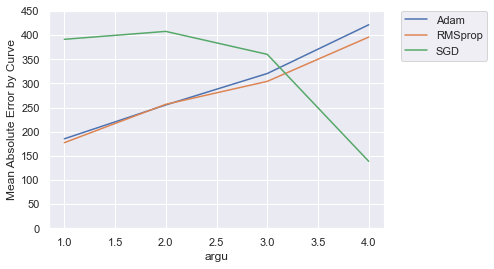

In [58]:
plot_tune_result('argu','opt','median')

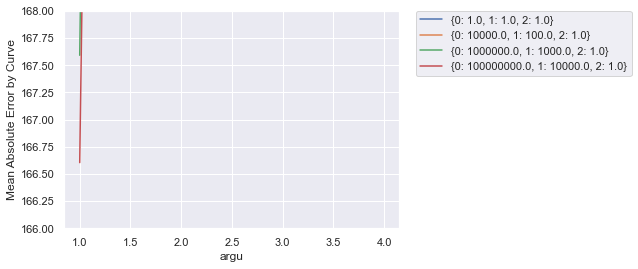

In [62]:
plot_tune_result('argu','class_weight','median',166,168)

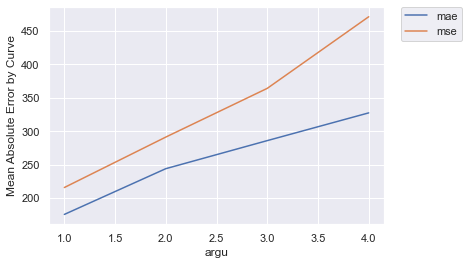

In [7]:
plot_tune_result('argu','loss_fun','median')

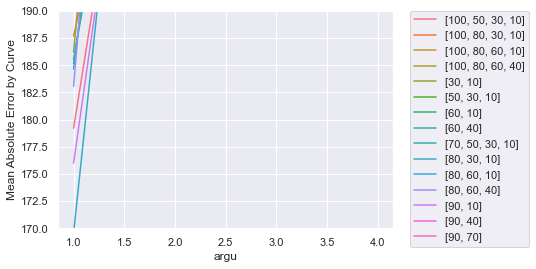

In [139]:
plot_tune_result('argu','nl','median',170,190)

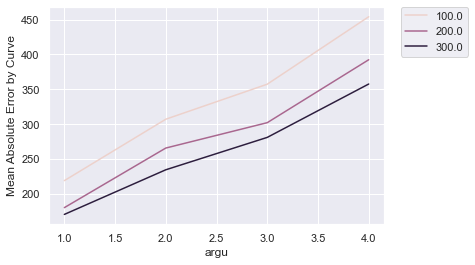

In [9]:
plot_tune_result('argu','epochs','median')

In [10]:
def plot_tune_result_3(arg1,arg2,arg3):
    output = result_all_selected.groupby([arg1,arg2,arg3])['error'].aggregate([np.mean,np.median]).reset_index()
    
    #palette = sns.color_palette("rocket_r",n_color = )
    # Plot the lines on two facets
    ax = sns.relplot(
            data=output,
            x= arg1, y= 'mean',
            hue= arg2, col= arg3,
            kind="line",
            height=10, aspect=.75, facet_kws=dict(sharex=False),
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax.set(xlabel='{}'.format(arg1), ylabel='Mean Absolute Error by Curve')
    plt.show()

No handles with labels found to put in legend.


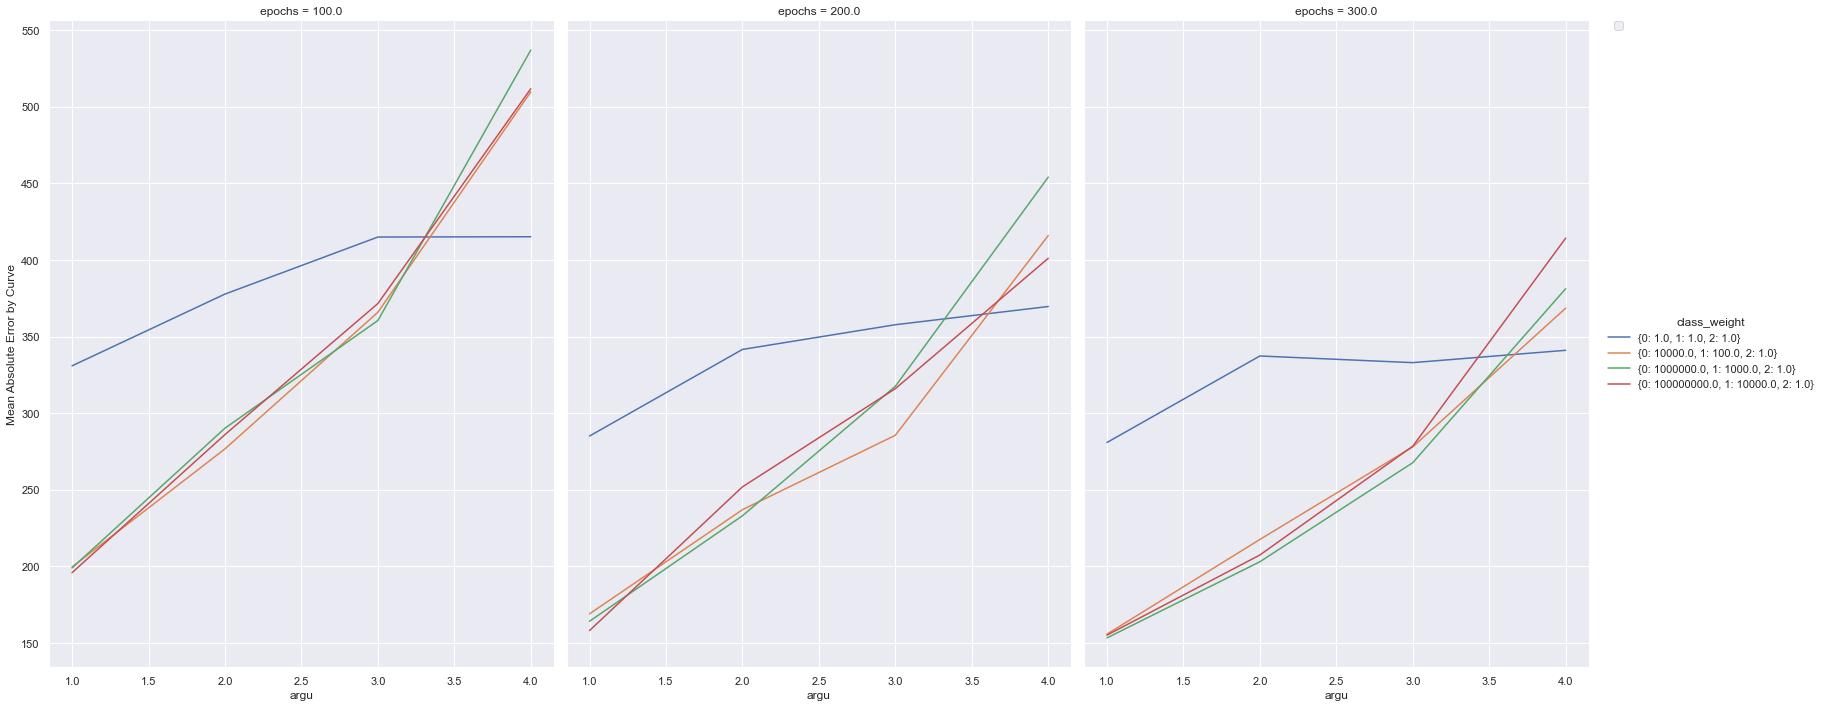

In [11]:
plot_tune_result_3('argu','class_weight','epochs')

No handles with labels found to put in legend.


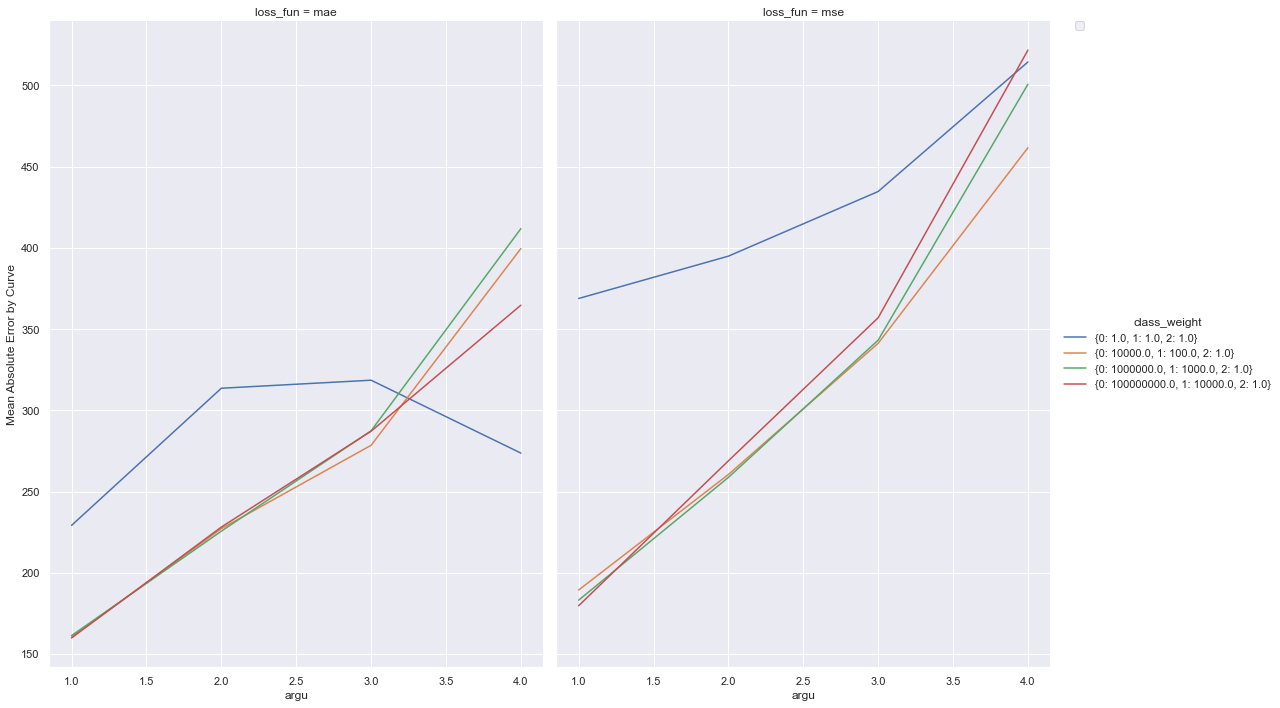

In [12]:
plot_tune_result_3('argu','class_weight','loss_fun')

# Result Selection # =====# Result Selection # =====# Result Selection # =====# Result Selection # =====

# 1. Data Preparation

## 1.1 Choose a Data Version

In [8]:
# 2nd Order Raw only!
test_coef = ["0","2","3","4","exponential"]
func_coef = ["raw","second","third","forth","exponential"]
for i in range(0,1):
    globals()[f'X{test_coef[i]}'],globals()[f'y{test_coef[i]}'],globals()[f'Y{test_coef[i]}'],globals()[f'X_Y_merged{test_coef[i]}'] = \
        eval(func_coef[i]+"_order_poly_fitting(all_metrics_df,testParamDf)")

version = '0' #raw ones
X,y,Y,X_Y_merged = eval('X'+version),eval('y'+version),eval('Y'+version),eval('X_Y_merged'+version)
objective = eval('objective_'+version)

## 1.2 Models Construction

In [9]:
model_raw = battery_model(0,X,y,Y,X_Y_merged,objective)

## 1.3 Data Argumentation

### (Reset)

# 2. Training

In [10]:
pd.options.mode.chained_assignment = None  # default='warn'

```python
index = 0  
for i0 in argu_all:
    model_raw_copy1 = copy.deepcopy(model_raw)
    model_raw_copy1.input_argumentation_update(i0)
    model_raw_copy2 = copy.deepcopy(model_raw_copy1)
    for i1 in loss_fun_all:
        for i2 in class_weight_all:
            for i3 in nl_all:
                for i4 in opt_all:
                    for i5 in epochs_all:
                        model_raw_copy = copy.deepcopy(model_raw_copy2)
                        result['argu'][index] = i0
                        result['loss_fun'][index] = i1
                        result['class_weight'][index] = "{}".format(i2)
                        result['nl'][index] = "{}".format(i3)
                        result['opt'][index] = i4
                        result['epochs'][index] = i5
                        result['error'][index] = model_raw_copy.model_construction_and_training(all_metrics_df,i1,i2,i3,i4,i5,0)
                        index+=1
                        print (i0,i1,i2,i3,i4,i5)
```


# Result

In [13]:
model_raw_copy = copy.deepcopy(model_raw)

2021-11-25 02:30:59.972746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-25 02:31:00.090779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-25 02:31:15.136979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-25 02:31:15.301843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-25 02:31:15.419001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-25 02:31:24.768006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-25 02:31:24.926544: I tensorflow/core/grappler/optimizers/cust

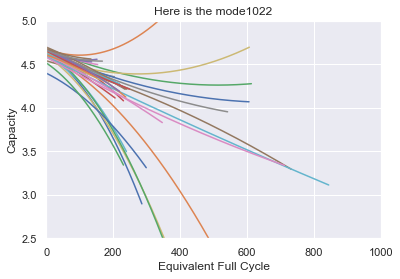

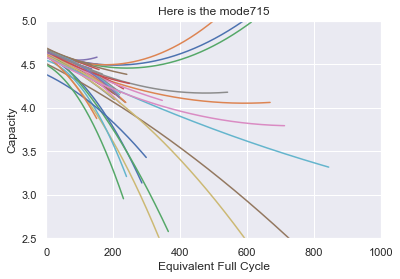

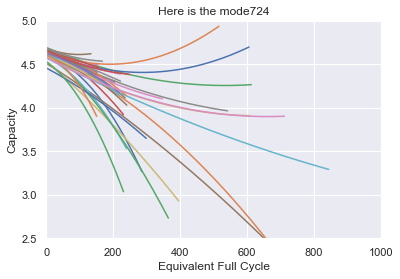

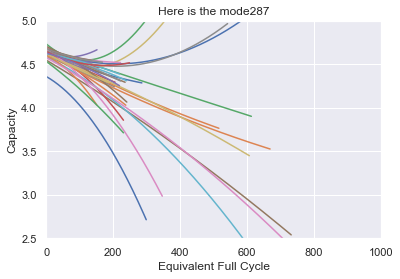

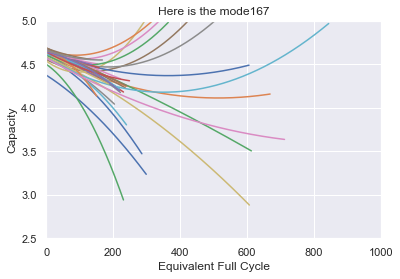

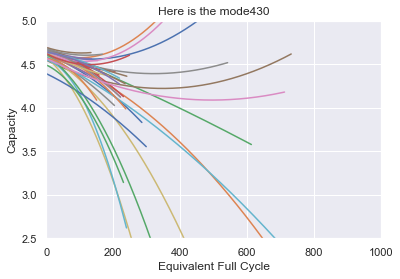

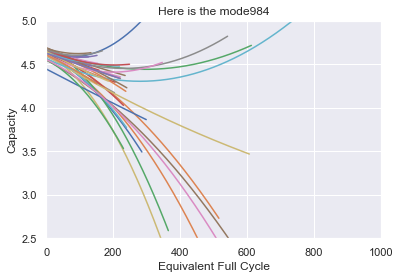

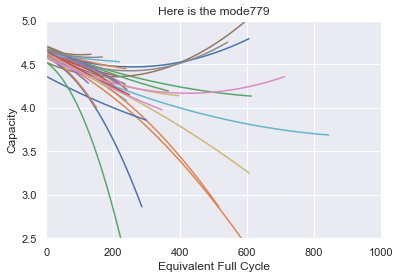

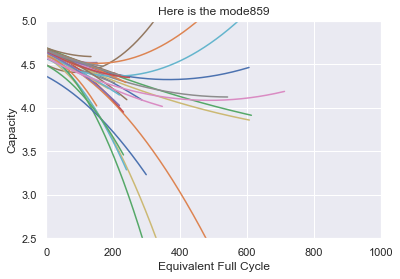

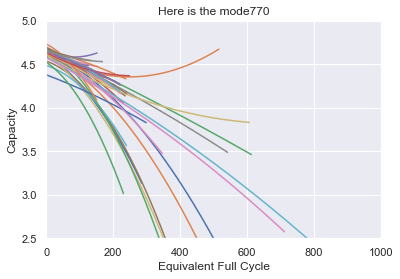

In [64]:
records = []
for i in arg1_selected:
    i0 = int(result_all['argu'][i])
    i1 = result_all['loss_fun'][i]
    i2 =eval(result_all['class_weight'][i])
    i3 = eval(result_all['nl'][i])
    i4 = result_all['opt'][i]
    i5 = int(result_all['epochs'][i])
    
    model_raw_copy1 = copy.deepcopy(model_raw_copy)
    model_raw_copy1.input_argumentation_update(i0)
    model_raw_copy2 = copy.deepcopy(model_raw_copy1)
    records.append(model_raw_copy2.model_construction_and_training(all_metrics_df,i1,i2,i3,i4,i5,0))
    plt.figure(i)
    model_raw_copy2.plot_curve("test",all_metrics_df,1000,2.5)
    plt.title("Here is the mode{}".format(i))


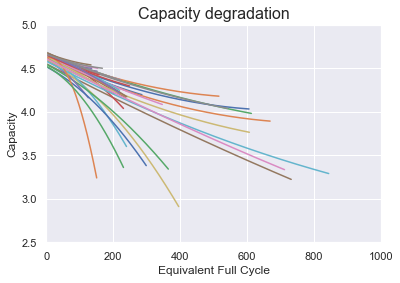

In [58]:
model_raw_copy2.plot_curve("test_true",all_metrics_df,1000,2.5)

In [65]:
print(arg1_selected)
print(records)
#Int64Index([1022, 715, 724, 287, 167, 430, 984, 779, 859, 770], dtype='int64')
#[#70.0375968367728, 58.746148234636394, 97.95740493221233, 127.04788390515586, 59.3923476813387,
# 163.9268530037394, 90.21623839484116, 53.02369699621675, 79.81441315464951, 67.98139775706916]

Int64Index([1022, 715, 724, 287, 167, 430, 984, 779, 859, 770], dtype='int64')
[53.4591756453927, 48.5841872133559, 41.29255765521055, 73.9179403836442, 88.44080670098884, 100.05325252084717, 111.98019537899728, 75.47465568908875, 107.56735425877427, 110.32648127072746]


In [68]:
records_array = np.array(records)
select = arg1_selected[np.argsort(records_array) == 0][0]
display(result_all.loc[select])
#859 - Good
#770 not bad
#3825 overfitting / underfitting???
# 3881 -> WHen input dimension high (4) -> Hard to differeate those value -> tend to predict the same
# reject 4 dimension argument 


Unnamed: 0                                 724
argu                                       1.0
loss_fun                                   mae
class_weight    {0: 10000.0, 1: 100.0, 2: 1.0}
nl                           [100, 80, 30, 10]
opt                                       Adam
epochs                                   200.0
error                                72.875277
Name: 724, dtype: object

In [11]:
i  = 287
i0 = int(result_all['argu'][i])
i1 = result_all['loss_fun'][i]
i2 =eval(result_all['class_weight'][i])
i3 = eval(result_all['nl'][i])
i4 = result_all['opt'][i]
i5 = int(result_all['epochs'][i])

model_raw_copy1 = copy.deepcopy(model_raw_copy)
model_raw_copy1.input_argumentation_update(i0)
model_raw_copy2 = copy.deepcopy(model_raw_copy1)
model_raw_copy2.model_construction_and_training('range',all_metrics_df,i1,i2,i3,i4,i5,0)

NameError: name 'result_all' is not defined

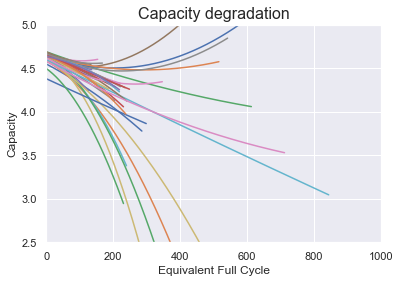

In [56]:
model_raw_copy2.plot_curve("test",all_metrics_df,1000,2.5)

In [14]:
i  = 287
i0 = int(result_all['argu'][i])
i1 = result_all['loss_fun'][i]
i2 =eval(result_all['class_weight'][i])
i3 = eval(result_all['nl'][i])
i4 = result_all['opt'][i]
i5 = int(result_all['epochs'][i])

model_raw_copy1 = copy.deepcopy(model_raw_copy)
model_raw_copy1.input_argumentation_update(i0)
model_raw_copy2 = copy.deepcopy(model_raw_copy1)
model_raw_copy2.model_construction_and_training('range',all_metrics_df,i1,i2,i3,i4,i5,0)

NameError: name 'result_all' is not defined

# Single Detection

In [32]:
i1 = 'mae'
i2 = {0: 100000000.0, 1: 10000.0, 2: 1.0}
i3 = [80,30,10]
i4 = 'Adam'
i5 = 250
model_raw_copy1 = copy.deepcopy(model_raw_copy)
model_raw_copy1.input_argumentation_update(1)
model_raw_copy2 = copy.deepcopy(model_raw_copy1)
model_raw_copy2.model_construction_and_training('range',all_metrics_df,i1,i2,i3,i4,i5,0)

2021-11-28 19:25:39.012428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-28 19:25:39.134772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2021-11-28 19:25:50.943857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[0.6276781980290913,
 0.8816140479720855,
 -4.944189354969369,
 -2.1193241320895777,
 0.9545952770372563,
 -0.24062143372892075,
 0.9509422191639261,
 -17.525603056523238,
 0.8794414693147818,
 -2.6427463035383263,
 0.29117512408101054,
 0.4744851696501847,
 0.9536353548633916,
 0.6351458155157705,
 -4.860292119406684,
 -7.343661541662547,
 0.772624604515847,
 0.9642073753883109,
 0.9592264049208372,
 -0.886045291830329,
 -168.98282260167937,
 0.6495231315491904,
 0.8211543157311063,
 -227.3133167060608,
 0.7115962197160709,
 -0.42453426525621163,
 0.5112580127454456,
 -17.685701223204052,
 0.190785780868588,
 0.8984562724004819,
 -38.22460639917443,
 -60.757176169988846,
 -1.4855780632931128,
 0.19533564039494922,
 0.998046431085355,
 0.5698620967975029,
 0.39768532866526796,
 -5.279217047281014,
 0.8700932876272107,
 -0.4010098391140766,
 0.14481394117391966,
 -76123.00809289866,
 0.9820225882541335,
 0.9663720847876791]

In [28]:
R_square_1 = model_raw_copy2.error
np.median(R_square_1),np.mean(R_square_1),np.mean(np.array(R_square_1) > 0.8)
#(0.5554604469539068, -1632.7457611477657, 0.29545454545454547)

(0.5554604469539068, -1632.7457611477657, 0.29545454545454547)

In [31]:
i1 = 'mae'
i2 = {0: 2.0, 1: 1.0, 2: 1.0}
i3 = [80,30,10]
i4 = 'Adam'
i5 = 250
model_raw_copy1 = copy.deepcopy(model_raw_copy)
model_raw_copy1.input_argumentation_update(1)
model_raw_copy22 = copy.deepcopy(model_raw_copy1)
model_raw_copy22.model_construction_and_training('zscore',all_metrics_df,i1,i2,i3,i4,i5,0)

2021-11-28 19:25:26.959937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-28 19:25:27.080047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2021-11-28 19:25:38.620086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[-26.08657128987044,
 0.9860780520472162,
 -5.092535876405692,
 0.9980433438226939,
 0.5906065713200666,
 -0.2532095831775387,
 0.9361068925441749,
 0.8309629990798857,
 0.3231629321227246,
 -0.36633945890826425,
 0.9734782252369205,
 0.993839230006853,
 0.9325500042346964,
 0.972576584901954,
 0.5330607537439289,
 -89.23218081532136,
 -0.549699871615374,
 0.7513342207198976,
 0.9459534551568518,
 0.9194200771565169,
 -74.48909356958502,
 0.9968818762517244,
 -0.25744292671751334,
 -13.969516574985802,
 -10.648238559551734,
 0.6420386814111908,
 0.9777111058044958,
 -7.7115529759371135,
 0.9934642360549578,
 0.994039601570634,
 -3.008572048988902,
 -58.67988495571588,
 0.6577962561505812,
 0.7747390263645477,
 0.6486771480460624,
 0.8831486145496354,
 0.28603555968310623,
 -28.3006001318485,
 0.8913276730450173,
 0.9548658373693152,
 -0.547804572629722,
 -56701.82559848229,
 0.9812459285469929,
 0.9432886244762141]

In [30]:
R_square_12 = model_raw_copy22.error
np.median(R_square_12),np.mean(R_square_12),np.mean(np.array(R_square_12) > 0.8)

(0.6424616381685537, -1213.1681557446261, 0.3181818181818182)

In [49]:
temp = []
for i in range(1,10):
    for k in range(1,5,2):
        if i <= 2:
            temp.append({0: i,
                        1: k,
                        2: 1})
        elif i%2==0:
            temp.append({0: i,
                        1: k,
                        2: 1})

In [50]:
temp

[{0: 1, 1: 1, 2: 1},
 {0: 1, 1: 3, 2: 1},
 {0: 2, 1: 1, 2: 1},
 {0: 2, 1: 3, 2: 1},
 {0: 4, 1: 1, 2: 1},
 {0: 4, 1: 3, 2: 1},
 {0: 6, 1: 1, 2: 1},
 {0: 6, 1: 3, 2: 1},
 {0: 8, 1: 1, 2: 1},
 {0: 8, 1: 3, 2: 1}]

In [47]:
2%2

0

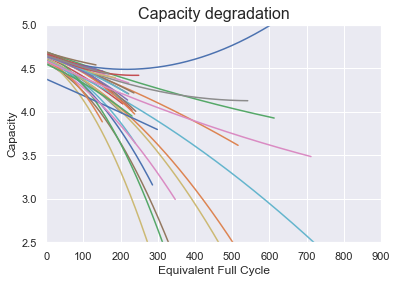

In [91]:
model_raw_copy2.plot_curve("test",all_metrics_df,900,2.5)

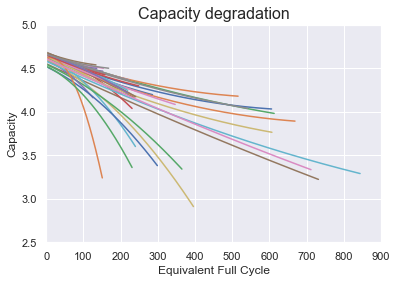

In [92]:
model_raw_copy2.plot_curve("test_true",all_metrics_df,900,2.5)

In [3]:
argu_all = np.arange(1,3)

loss_fun_0 = 'mse'
loss_fun_1 = 'mae'
loss_fun_all = [loss_fun_0,loss_fun_1]

class_weight_all = []
for i in range(1,10):
    for k in range(1,5,2):
        if i <= 2:
            class_weight_all.append({0: i,
                                1: k,
                                2: 1})
        elif i%2==0:
            class_weight_all.append({0: i,
                                1: k,
                                2: 1})
nl_all = []
for i in range(10,101,30):
    for j in range(i+30,101,30):
        nl_all.append([j,i])
        for k in range(j+30,101,30):
            nl_all.append([k,j,i])
            for z in range(k+30,101,30):
                nl_all.append([z,k,j,i])
opt_all = ['Adam', 'RMSprop']
epochs_all = [150,300]
rows = len(argu_all)*len(loss_fun_all)*len(class_weight_all)*len(nl_all) *len(opt_all)*len(epochs_all)

In [2]:
import numpy as np
np.arange(1,3)

array([1, 2])

In [4]:
class_weight_all

[{0: 1, 1: 1, 2: 1},
 {0: 1, 1: 3, 2: 1},
 {0: 2, 1: 1, 2: 1},
 {0: 2, 1: 3, 2: 1},
 {0: 4, 1: 1, 2: 1},
 {0: 4, 1: 3, 2: 1},
 {0: 6, 1: 1, 2: 1},
 {0: 6, 1: 3, 2: 1},
 {0: 8, 1: 1, 2: 1},
 {0: 8, 1: 3, 2: 1}]

In [5]:
nl_all

[[40, 10],
 [70, 40, 10],
 [100, 70, 40, 10],
 [100, 40, 10],
 [70, 10],
 [100, 70, 10],
 [100, 10],
 [70, 40],
 [100, 70, 40],
 [100, 40],
 [100, 70]]